<a href="https://colab.research.google.com/github/athiraa12/automl-fulfillment-delay-predictor/blob/main/AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# TPOT is not pre-installed, so install it
!pip install tpot




In [ ]:
import pandas as pd
import numpy as np

np.random.seed(1)

data = []
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for i in range(200):
    day = np.random.choice(days)
    orders = np.random.randint(100, 500)
    workers = np.random.randint(5, 30)
    pick_time = np.random.uniform(2, 7)  # average pick time in minutes
    shift = np.random.randint(6, 10)

    # Logic: too many orders + few workers + slow pick time = delay
    delay = 1 if (orders/workers > 18 and pick_time > 5) else 0

    data.append([day, orders, workers, round(pick_time, 2), shift, delay])

df = pd.DataFrame(data, columns=['day', 'orders_received', 'workers_available', 'avg_pick_time', 'shift_hours', 'delay_occurred'])

df.head()


,day,orders_received,workers_available,avg_pick_time,shift_hours,delay_occurred
0,Sat,335,17,6.66,7,1
1,Thu,233,20,3.18,7,0
2,Fri,171,18,5.35,7,0
3,Wed,376,10,5.43,9,1
4,Fri,256,19,5.35,9,0


In [ ]:
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

# Convert 'day' to numeric
df['day'] = df['day'].astype('category').cat.codes

# Define features and target
X = df.drop('delay_occurred', axis=1)
y = df['delay_occurred']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize TPOT (no verbosity or score method)
tpot = TPOTClassifier(generations=5, population_size=20, random_state=42)
tpot.fit(X_train, y_train)

# Use the fitted pipeline directly
best_model = tpot.fitted_pipeline_
accuracy = best_model.score(X_test, y_test)

print("Best pipeline model:\n", best_model)
print("Test Accuracy Score:", accuracy)



/usr/local/lib/python3.11/dist-packages/tpot/tpot_estimator/estimator.py:458: UserWarning: Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.
  warnings.warn("Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.")
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:33967
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44165'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:39143 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:39143
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:55286
INFO:distributed.scheduler:Receive client connection: Client-0391624a-58ea-11f0-8e0b-0242ac1c000c
INFO:distributed.core:Starting established con

Best pipeline model:
 Pipeline(steps=[('normalizer', Normalizer(norm=np.str_('l2'))),
                ('selectfrommodel',
                 SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=np.True_,
                                                                class_weight='balanced',
                                                                criterion=np.str_('entropy'),
                                                                max_features=0.1035557631159,
                                                                min_samples_leaf=11,
                                                                min_samples_split=13,
                                                                n_jobs=1,
                                                                random_state=42),
                                 threshold=0.0084536361245)),
                ('featureunion-1',
                 FeatureU...nsformer_list=[('skiptransformer',
                              

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


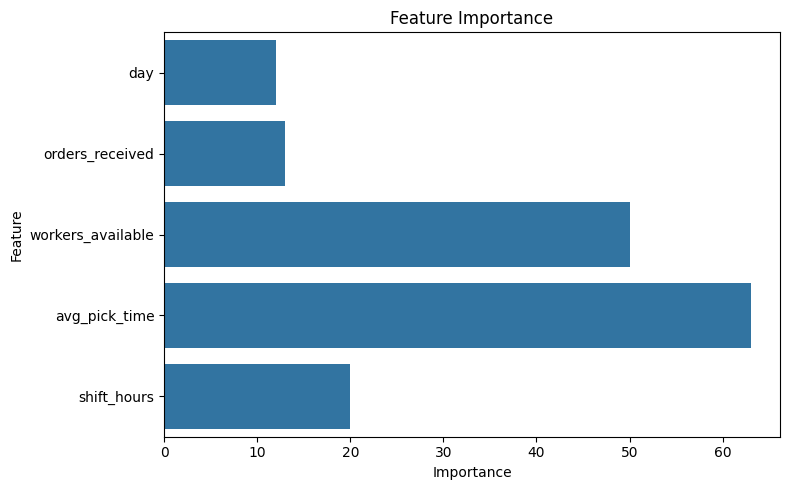

In [ ]:
# Get the final model from TPOT's pipeline
model = tpot.fitted_pipeline_[-1]  # This gets the LGBMClassifier at the end

# Match feature importances to column names
import matplotlib.pyplot as plt
import seaborn as sns

feature_names = X.columns
importances = model.feature_importances_

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


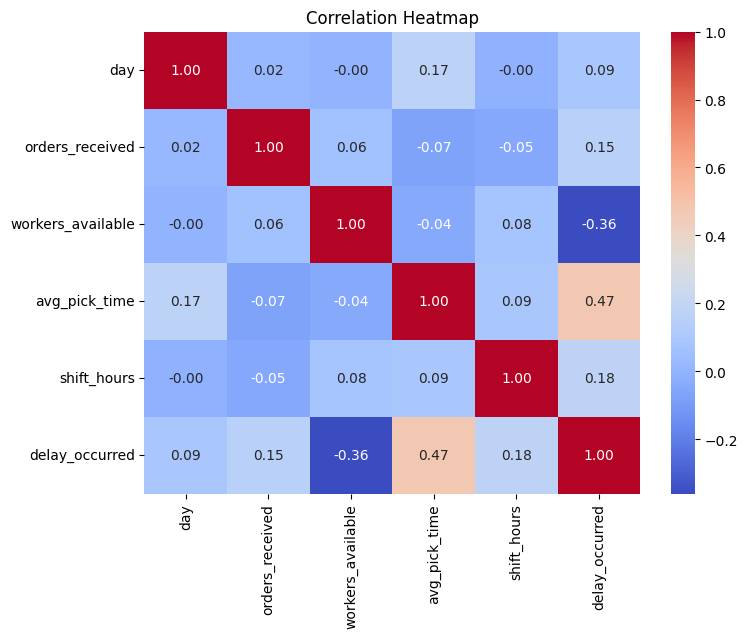

In [ ]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
delays = df[df['delay_occurred'] == 1]
no_delays = df[df['delay_occurred'] == 0]

print("Average for DELAY days:")
print(delays[['orders_received', 'workers_available', 'avg_pick_time']].mean())

print("\nAverage for NON-DELAY days:")
print(no_delays[['orders_received', 'workers_available', 'avg_pick_time']].mean())


Average for DELAY days:
orders_received      341.189189
workers_available     11.594595
avg_pick_time          5.924054
dtype: float64

Average for NON-DELAY days:
orders_received      294.079755
workers_available     18.478528
avg_pick_time          4.146748
dtype: float64


In [ ]:
def suggest_action(row):
    workload_ratio = row['orders_received'] / row['workers_available']

    if workload_ratio > 20 and row['avg_pick_time'] > 5:
        return "⚠️ Add more workers or split workload"
    elif row['avg_pick_time'] > 6:
        return "📦 Reorganize storage layout to reduce pick time"
    elif workload_ratio > 22:
        return "👥 Schedule backup staff during peak hours"
    elif row['shift_hours'] < 7:
        return "⏱️ Extend shift hours or overlap shifts"
    else:
        return "✅ Operations are optimal"

df['recommendation'] = df.apply(suggest_action, axis=1)


In [ ]:
df[['orders_received', 'workers_available', 'avg_pick_time', 'shift_hours', 'delay_occurred', 'recommendation']].head(10)


,orders_received,workers_available,avg_pick_time,shift_hours,delay_occurred,recommendation
0,335,17,6.66,7,1,📦 Reorganize storage layout to reduce pick time
1,233,20,3.18,7,0,✅ Operations are optimal
2,171,18,5.35,7,0,✅ Operations are optimal
3,376,10,5.43,9,1,⚠️ Add more workers or split workload
4,256,19,5.35,9,0,✅ Operations are optimal
5,341,28,6.70,8,0,📦 Reorganize storage layout to reduce pick time
6,493,12,3.57,8,0,👥 Schedule backup staff during peak hours
7,101,5,6.47,6,1,⚠️ Add more workers or split workload
8,241,24,2.85,7,0,✅ Operations are optimal
9,130,12,4.11,7,0,✅ Operations are optimal
